In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import scipy.stats as stats
import matplotlib.pyplot as plt

import boto3
from io import BytesIO

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [278]:
# testing file
# file = xr.open_dataset('/Users/victoriaford/Downloads/ASOSAWOS_72053900165.nc')
file = xr.open_dataset('/Users/victoriaford/Desktop/Train_Files/CAHYDRO_SQBC1.nc') # has flagged vars

df = file.to_dataframe()
df = df.reset_index() 
df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable

In [279]:
def create_bins(data, bin_size=0.25):
    '''Create bins from data covering entire data range'''

    # set up bins
    b_min = np.floor(np.nanmin(data))
    b_max = np.ceil(np.nanmax(data))
    bins = np.arange(b_min - bin_size, b_max + (3. * bin_size), bin_size)

    return bins

def iqr_standardize(df, var):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    iqr = q3 - q1
    
    return (df[var].values - df[var].median()) / iqr

def pdf_bounds(df, mu, sigma, bins):
    '''Calculate pdf distribution, return pdf and threshold bounds'''

    y = stats.norm.pdf(bins, mu, sigma)
    
    # add vertical lines to indicate thresholds where pdf y=0.1
    pdf_bounds = np.argwhere(y > 0.1)

    # find first index
    left_bnd = round(bins[pdf_bounds[0][0] -1])
    right_bnd = round(bins[pdf_bounds[-1][0] + 1])
    thresholds = (left_bnd - 1, right_bnd + 1)
    
    return (y, left_bnd - 1, right_bnd + 1)

def monthly_med(df):
    """Calculates the monthly median"""
    return df.resample('M', on='time').median(numeric_only=True)


def qaqc_dist_whole_stn_bypass_check(df, vars_to_check, min_num_months=5):
    """
    Checks the number of valid observation months in order to proceed through 
    monthly distribution checks. Identifies whether a station record has too 
    few months and produces a fail pass flag. 
    """
    
    # set up df
    df = df.reset_index() 
    df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
    df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable
             
    # set up a "pass_flag" to determine if station proceeds through distribution function
    pass_flag = 'pass'
    
    for var in vars_to_check:
        # add _eraqc column for each variable
        df[var+'_eraqc'] = np.nan # default value of nan    
    
        for month in range(1,13):

            # first check num of months in order to continue
            month_to_check = df.loc[df['month'] == month]

            # check for number of obs years
            if (len(month_to_check.year.unique()) < 5):
                df[var+'_eraqc'] = 18 # see era_qaqc_flag_meanings.csv
                pass_flag = 'fail'

    err_statement = '{} has too short of an observation record to proceed through the monthly distribution qa/qc checks -- bypassing station'.format(
                    df['station'].unique()[0])
    
    if pass_flag == 'fail':
        print(err_statement)
                
    return (df, pass_flag) 


def qaqc_dist_var_bypass_check(df, vars_to_check, min_num_months=5):
    """
    Checks the number of valid observation months per variable
    to proceed through monthly distribution checks.
    Primarily assesses whether if null values persist for a month
    """
        
    for var in vars_to_check:
        for month in range(1,13):
            monthly_df = df.loc[df['month']==month]
            
            # if all values are null for that month across years
            if monthly_df[var].isnull().all() == True:
                df[var+'_eraqc'] = 19 # see era_qaqc_flag_meanings.csv
            
            # if not all months have nans, need to assess how many years do
            elif monthly_med(df).loc[monthly_med(df)['month'] == month][var].isna().sum() > min_num_months:
#                 print('{} has less than {} months of valid {} observations -- bypassing check'.format(
#                 df['station'].unique()[0], min_num_months, var))
                
                df[var+'_eraqc'] = 19 # see era_qaqc_flag_meanings.csv
        
    return df

def iqr_range(df, month, var):
    """Calculates the monthly interquartile range"""
    q1 = df.groupby('month').quantile(0.25, numeric_only=True)
    q3 = df.groupby('month').quantile(0.75, numeric_only=True)
    iqr_df = q3 - q1
    
    iqr_val = iqr_df.loc[iqr_df.index == month]
    
    # inflated to 4°C or 4 hPa for months with very small IQR
    var_check = ['tas', 'tdps', 'tdps_derived', 'ps', 'psl', 'psl_altimeter']
    if iqr_val[var].values < 4:
        if var in var_check:
            iqr_val[var].values = 4
    
    return iqr_val[var].values


def median_clim(df, month, var):
    '''Calculate climatological median for a specific month and variable'''
    
    clim = df[var].median(numeric_only=True)
    
    return clim

In [280]:
def dist_gap_part2_plot(df, month, var, network):
    
    # subset by month
    df = df.loc[df['month'] == month]
    
    # standardize against IQR range
    df_month_iqr = iqr_standardize(df, var)
    
    # determine number of bins
    bins = create_bins(df_month_iqr)
    
    # plot histogram
    ax = plt.hist(df_month_iqr, bins=bins, log=False, density=True, alpha=0.3);
    xmin, xmax = plt.xlim()
    plt.ylim(ymin=0.1)
    
    # pdf
    mu = np.nanmean(df_month_iqr)
    sigma = np.nanstd(df_month_iqr)
    y, left_bnd, right_bnd = pdf_bounds(df_month_iqr, mu, sigma, bins)
    l = plt.plot(bins, y, 'k--', linewidth=1)

    # bounds from distribution rounded up to nearest integer + 1
    plt.axvline(right_bnd, color='r') # right tail
    plt.axvline(left_bnd, color='r') # left tail
    
    # flag (visually) obs that are beyond threshold
    for bar in ax[2].patches:
        x = bar.get_x() + 0.5 * bar.get_width()
        if x > right_bnd: # right tail
            bar.set_color('r')
        elif x < left_bnd: # left tail
            bar.set_color('r')

    # title and useful annotations
    plt.title('Distribution gap check pt 2: {0}: {1}'.format(df['station'].unique()[0], var), fontsize=10);
    plt.annotate('Month: {}'.format(month), xy=(0.025, 0.95), xycoords='axes fraction', fontsize=8);
    plt.annotate('Mean: {}'.format(round(mu,3)), xy=(0.025, 0.9), xycoords='axes fraction', fontsize=8);
    plt.annotate('Std.Dev: {}'.format(round(sigma,3)), xy=(0.025, 0.85), xycoords='axes fraction', fontsize=8);
    plt.ylabel('Frequency (obs)')
    
    # save figure to AWS
    bucket_name = 'wecc-historical-wx'
    directory = '3_qaqc_wx'
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)
    
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    figname = 'qaqc_dist_gap_check_part2_{0}_{1}_{2}'.format(df['station'].unique()[0], var, month)
#     bucket.put_object(Body=img_data, ContentType='image/png',
#                      Key='{0}/{1}/qaqc_figs/{2}.png'.format(
#                      directory, network, figname))

IndexError: index 0 is out of bounds for axis 0 with size 0

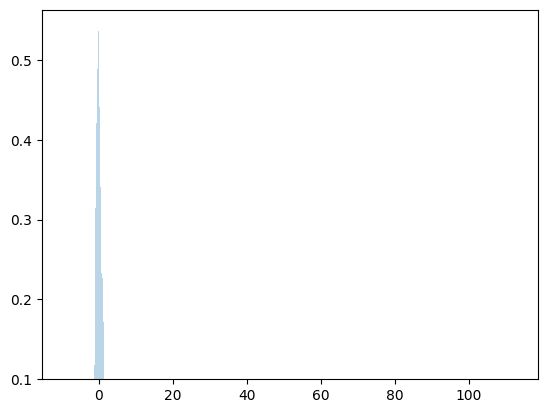

In [281]:
dist_gap_part2_plot(df, month=5, var='tas', network='CAHYDRO')

In [284]:
def qaqc_dist_gap_part2(df, plot=True):
    """
    Part 2 / monthly check
        - compare all obs in a single month, all years
        - histogram created from all obs and gaussian distribution fitted
        - threshold values determined using positions where fitted freq falls below y=0.1
        - rounds outwards to next integer plus one
        - going outwards from center, distribution is scanned for gaps which occur outside threshold
        - obs beyond gap are flagged
    Goal: identifies individual suspect observations and flags the entire month  
    """
    # run through every var, excluding qaqc/duration/method vars
    vars_to_remove = ['index','station','qc','duration','method','lat','lon','elevation','time','month','year','sfcWind_dir'] # list of var substrings to exclude if present in var
    vars_to_check = [var for var in df.columns if not any(True for item in vars_to_remove if item in var)] # remove all non-primary variables
        
    # whole station bypass check first
    df, pass_flag = qaqc_dist_whole_stn_bypass_check(df, vars_to_check)
    
    if pass_flag != 'fail':
        
        for var in vars_to_check:
            for month in range(1,13):
                
                # per variable bypass check
                df = qaqc_dist_var_bypass_check(df, vars_to_check) # flag here is 19
                if 19 in df[var+'_eraqc']:
                    continue # skip variable 
                
                # station has above min_num_months number of valid observations, proceed with dist gap check
                else:
                    # from center of distribution, scan for gaps (where bin = 0)
                    # when gap is found, and it is at least 2x bin width
                    # any bins beyond end of gap + beyond threshold value are flagged
                    
                    # subset by month
                    df = df.loc[df['month'] == month]
                    
                    # standardize against IQR range
                    df_month_iqr = iqr_standardize(df, var)

                    # determine number of bins
                    bins = create_bins(df_month_iqr)
                    
                    # pdf
                    mu = np.nanmean(df_month_iqr)
                    sigma = np.nanstd(df_month_iqr)

                    y, left_bnd, right_bnd = pdf_bounds(df_month_iqr, mu, sigma, bins)
                    
                    # identify gaps as below y=0.1 from histogram, not pdf                    
                    y_hist, bins = np.histogram(df_iqr, bins=bins, density=True)
                    
                    # identify climatology and iqr baselines in order to flag
                    iqr_baseline = iqr_range(df, month=month, var=var)
                    clim = median_clim(df, month=month, var=var)
                                        
                    # gaps are only flagged for values beyond left_bnd, right_bnd, as long as gap is 2*bin_width (2*0.25)
                    # considering that the # of bins for threshold is (4,7) from y=0.1
                    # safe to assume that gap is present if values >0.1 outside of left_bnd, right_bnd
                    bins_beyond_left_bnd = np.argwhere(bins <= left_bnd)
                    if len(bins_beyond_left_bnd) != 0: 
                        for data in bins_beyond_left_bnd:
                            if y_hist[data] > 0.1: # bins with data > 0.1 beyond left_bnd
                                
                                # identify values beyond left bnd
                                vals_to_flag = clim + (left_bnd * iqr_baseline) # left_bnd is negative
                                df.loc[df[var] <= vals_to_flag[0], var+'_eraqc'] = 21 # see era_qaqc_flag_meanings.csv


                    bins_beyond_right_bnd = np.argwhere(bins >= right_bnd)
                    if len(bins_beyond_right_bnd) != 0:
                        for data in bins_beyond_right_bnd:
                            if y_hist[data] > 0.1: # bins with data > 0.1 beyond right_bnd
                                
                                # identify values beyond right bnd
                                vals_to_flag = clim + (right_bnd * iqr_baseline) # upper limit threshold
                                df.loc[df[var] >= vals_to_flag[0], var+'_eraqc'] = 21 # see era_qaqc_flag_meanings.csv
                    
    ## Question: Do we need "all", "flagged_only", "none" options instead?
    if plot==True:
        for month in range(1,13):
            for var in vars_to_check:
                if 19 not in df[var+'_eraqc'].values: # don't plot a figure if it's all nans/not enough months
                    dist_gap_part2_plot(df, month, var, 
                                        network=df['station'].unique()[0].split('_')[0])

    
    return df

IndexError: index 0 is out of bounds for axis 0 with size 0

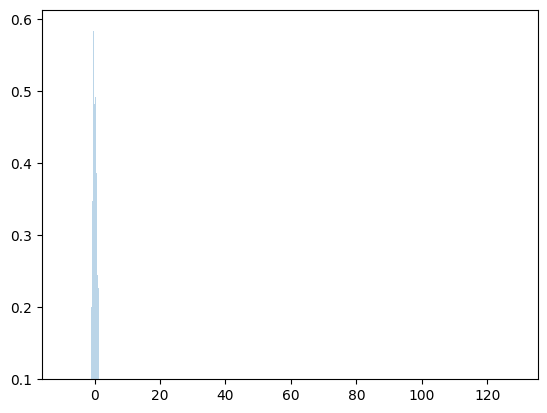

In [285]:
df3 = qaqc_dist_gap_part2(df)

In [287]:
month=1
var='tas'

In [286]:
df

,station,time,tas,pr,tas_qc,elevation,lat,lon,month,year
0,CAHYDRO_SQBC1,2010-05-27 15:53:00,273.720,NaN,nan,1910.7912,39.195,-120.2294,5,2010
1,CAHYDRO_SQBC1,2010-05-27 16:23:00,274.270,NaN,nan,1910.7912,39.195,-120.2294,5,2010
2,CAHYDRO_SQBC1,2010-05-27 16:53:00,274.270,NaN,nan,1910.7912,39.195,-120.2294,5,2010
3,CAHYDRO_SQBC1,2010-05-27 17:23:00,274.830,NaN,nan,1910.7912,39.195,-120.2294,5,2010
4,CAHYDRO_SQBC1,2010-05-27 17:53:00,274.830,NaN,nan,1910.7912,39.195,-120.2294,5,2010
...,...,...,...,...,...,...,...,...,...,...
57706,CAHYDRO_SQBC1,2022-08-17 01:10:00,313.717,NaN,1,1910.7912,39.195,-120.2294,8,2022
57707,CAHYDRO_SQBC1,2022-08-18 05:34:00,207.606,NaN,1,1910.7912,39.195,-120.2294,8,2022
57708,CAHYDRO_SQBC1,2022-08-25 02:59:00,199.828,NaN,1,1910.7912,39.195,-120.2294,8,2022
57709,CAHYDRO_SQBC1,2022-08-27 23:02:00,310.939,NaN,1,1910.7912,39.195,-120.2294,8,2022


In [289]:
df = df.loc[df['month'] == month]

# standardize against IQR range
df_month_iqr = iqr_standardize(df, var)
df_month_iqr

array([-0.7334934 , -0.7334934 , -0.79951981, ..., -8.60288115,
       -5.33493397, -5.93517407])

In [290]:
# determine number of bins
bins = create_bins(df_month_iqr)
bins

array([ -9.25,  -9.  ,  -8.75,  -8.5 ,  -8.25,  -8.  ,  -7.75,  -7.5 ,
        -7.25,  -7.  ,  -6.75,  -6.5 ,  -6.25,  -6.  ,  -5.75,  -5.5 ,
        -5.25,  -5.  ,  -4.75,  -4.5 ,  -4.25,  -4.  ,  -3.75,  -3.5 ,
        -3.25,  -3.  ,  -2.75,  -2.5 ,  -2.25,  -2.  ,  -1.75,  -1.5 ,
        -1.25,  -1.  ,  -0.75,  -0.5 ,  -0.25,   0.  ,   0.25,   0.5 ,
         0.75,   1.  ,   1.25,   1.5 ,   1.75,   2.  ,   2.25,   2.5 ,
         2.75,   3.  ,   3.25,   3.5 ,   3.75,   4.  ,   4.25,   4.5 ,
         4.75,   5.  ,   5.25,   5.5 ,   5.75,   6.  ,   6.25,   6.5 ,
         6.75,   7.  ,   7.25,   7.5 ,   7.75,   8.  ,   8.25,   8.5 ,
         8.75,   9.  ,   9.25,   9.5 ,   9.75,  10.  ,  10.25,  10.5 ,
        10.75,  11.  ,  11.25,  11.5 ,  11.75,  12.  ,  12.25,  12.5 ,
        12.75,  13.  ,  13.25,  13.5 ,  13.75,  14.  ,  14.25,  14.5 ,
        14.75,  15.  ,  15.25,  15.5 ,  15.75,  16.  ,  16.25,  16.5 ,
        16.75,  17.  ,  17.25,  17.5 ,  17.75,  18.  ,  18.25,  18.5 ,
      

In [291]:
# pdf
mu = np.nanmean(df_month_iqr)
sigma = np.nanstd(df_month_iqr)

In [292]:
mu, sigma

(1.43995316983937, 11.070317221778254)

In [294]:
def pdf_bounds(df, mu, sigma, bins):
    '''Calculate pdf distribution, return pdf and threshold bounds'''

    y = stats.norm.pdf(bins, mu, sigma)
    
    # add vertical lines to indicate thresholds where pdf y=0.1
    pdf_bounds = np.argwhere(y > 0.1)

    # find first index
    left_bnd = round(bins[pdf_bounds[0][0] -1])
    right_bnd = round(bins[pdf_bounds[-1][0] + 1])
    thresholds = (left_bnd - 1, right_bnd + 1)
    
    return (y, left_bnd - 1, right_bnd + 1)


In [295]:
y = stats.norm.pdf(bins, mu, sigma)

In [297]:
pdf_bounds = np.argwhere(y > 0.1)

In [300]:
y_hist, bins = np.histogram(df_iqr, bins=bins, density=True)

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01843318, 0.03686636, 0.07373272, 0.11059908,
        0.11059908, 0.1843318 , 0.12903226, 0.0921659 , 0.31336406,
        0.47926267, 0.36866359, 0.60829493, 0.60829493, 0.31336406,
        0.23963134, 0.22119816, 0.03686636, 0.05529954, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

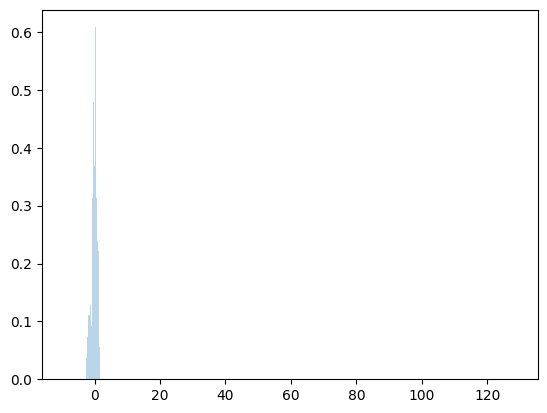

In [302]:
plt.hist(df_iqr, bins=bins, log=False, density=True, alpha=0.3)

<Axes: ylabel='Frequency'>

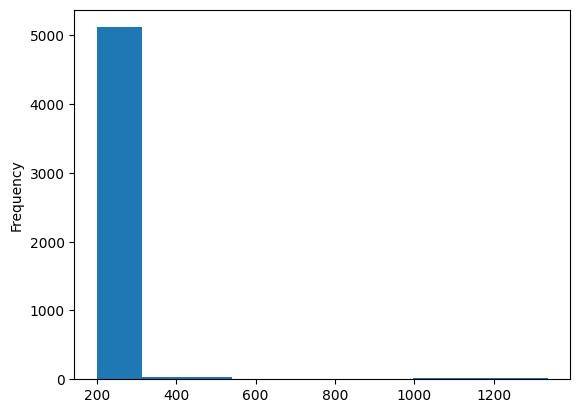

In [304]:
df['tas'].plot.hist()

In [305]:
df['tas'].median()

271.48999999999995

In [311]:
df.loc[df['tas'] > 350]['tas'].unique()

array([ 437.41,  370.94,  418.16,  401.49,  420.94,  360.38,  862.61,
       1335.38, 1253.16,  690.94,  442.05,  768.16,  452.05,  424.83,
        844.27,  390.94, 1272.05,  929.83, 1153.16,  403.72,  520.38,
       1182.05, 1054.27,  534.83,  507.61, 1317.05, 1208.72,  420.38,
        663.16,  980.94,  927.05,  604.83,  555.38,  561.49, 1142.61,
       1184.83, 1135.94, 1303.16,  602.05, 1053.72, 1140.94,  598.72,
       1263.72,  605.38, 1240.94,  512.61,  580.38, 1328.16,  391.49,
        397.61,  884.83,  540.94, 1247.61,  374.27,  674.83,  538.72,
        479.83,  599.83, 1057.61,  487.05,  376.49, 1176.49,  712.61,
        911.49,  998.72,  827.05, 1233.16,  691.49,  982.61, 1056.49,
        770.94, 1337.05, 1157.05, 1065.38,  419.27,  769.27, 1060.94,
       1024.27,  626.49,  489.27,  369.83,  404.27, 1019.83, 1035.94,
       1302.61, 1070.38, 1147.05,  817.61, 1179.27,  575.38,  790.38,
       1327.05, 1237.05,  468.72, 1251.49,  498.16, 1072.05, 1107.61,
       1205.38,  484

<Axes: >

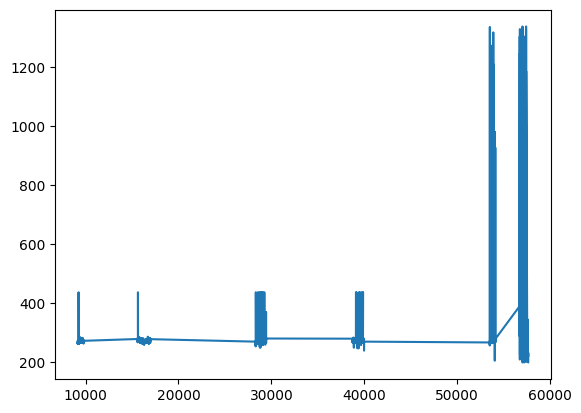

In [312]:
df['tas'].plot()